# Finetune YOLOv8 from Grounding DINO

<div align="center">

  <a href="https://ultralytics.com/yolov8" target="_blank">
    <img width="1024", src="https://raw.githubusercontent.com/ultralytics/assets/main/yolov8/banner-yolov8.png"></a>


<br>
  <a href="https://console.paperspace.com/github/ultralytics/ultralytics"><img src="https://assets.paperspace.io/img/gradient-badge.svg" alt="Run on Gradient"/></a>
  <a href="https://colab.research.google.com/github/ultralytics/ultralytics/blob/main/examples/tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
  <a href="https://www.kaggle.com/ultralytics/yolov8"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"></a>
<br>

Welcome to the Ultralytics YOLOv8 🚀 notebook! <a href="https://github.com/ultralytics/ultralytics">YOLOv8</a> is the latest version of the YOLO (You Only Look Once) AI models developed by <a href="https://ultralytics.com">Ultralytics</a>. This notebook serves as the starting point for exploring the various resources available to help you get started with YOLOv8 and understand its features and capabilities.

YOLOv8 models are fast, accurate, and easy to use, making them ideal for various object detection and image segmentation tasks. They can be trained on large datasets and run on diverse hardware platforms, from CPUs to GPUs.

We hope that the resources in this notebook will help you get the most out of YOLOv8. Please browse the YOLOv8 <a href="https://docs.ultralytics.com/">Docs</a> for details, raise an issue on <a href="https://github.com/ultralytics/ultralytics">GitHub</a> for support, and join our <a href="https://ultralytics.com/discord">Discord</a> community for questions and discussions!

</div>

## 1. Setup

Based on [medium](https://medium.com/@yongsun.yoon/fine-tuning-yolov8-using-custom-dataset-generated-by-open-world-object-detector-5724e267645d).



In traditional object detection, models are trained to detect objects from a predefined set of categories. Open-world (also called as open-vocabulary or open-set) object detection aims to solve this problem by allowing models to detect arbitrary classes.

Many open-world object detectors leverage vision-language multi-modal training, allowing them to detect the objects of classes that written in human text by fusing the representations of image and language.

______________


Unfortunately, the large size of open-world object detectors makes it difficult to use it in low-resource environments. If we want to detect fixed set of classes (but not included in the benchmark datasets), we can use them as dataset labelers. By fine-tuning small object detection models, such as YOLO, with the generated dataset, we can obtain custom and efficient object detector.


In [ ]:
# setup GroundingDINO
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO
!pip install -q -e .
%cd ..
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 463 (delta 175), reused 135 (delta 135), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 16.90 MiB/s, done.
Resolving deltas: 100% (241/241), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 15.5 MB/s eta 0:00:00
/content


In [ ]:
!pip install -q ultralytics datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.0/874.0 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import sys
sys.path.append('GroundingDINO')

In [ ]:
import os
import yaml
import numpy as np
import supervision as sv
from PIL import Image
from tqdm.auto import tqdm
from ultralytics import YOLO
from datasets import load_dataset
from groundingdino.util.inference import load_model, load_image, predict, annotate

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 2. Grounding DINO

### Custom Dataset Generation by Open-world Object Detector

To train new class to pretrained object detector, we can chose “food” class and Grounding DINO for open-world object detection. GroundingDINO extends a closed-set detector DINO by performing vision-language modality fusion at multiple phases.

The framework of Grounding DINO is presented below.

<div align="center">

  <a href="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*1byo0nLGRhAZln508M3abw.png" target="_blank">
    <img width="1024", src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*1byo0nLGRhAZln508M3abw.png"></a>

In [ ]:
def run_dino(dino, image, text_prompt='food', box_threshold=0.4, text_threshold=0.1):
    boxes, logits, phrases = predict(
        model = dino,
        image = image,
        caption = text_prompt,
        box_threshold = box_threshold,
        text_threshold = text_threshold
    )
    return boxes, logits, phrases

In [ ]:
dino = load_model('GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py', 'groundingdino_swint_ogc.pth')

final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

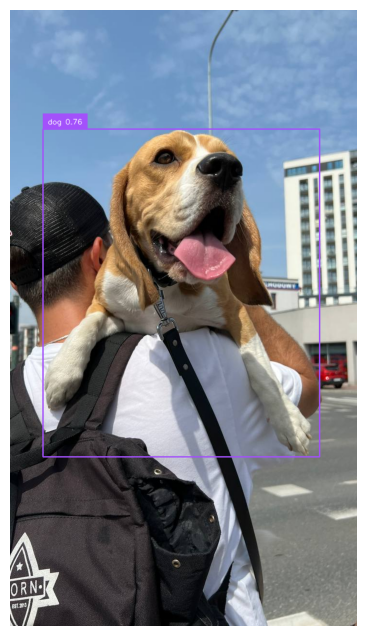

In [ ]:
os.system('wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg')

image_source, image = load_image('dog.jpeg')
boxes, logits, phrases = run_dino(dino, image, text_prompt='dog')

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_frame, (8, 8))

## 3. Annotate Dataset

In [ ]:
def annotate(dino, data, data_size, data_dir):
    data = data.train_test_split(train_size=min(len(data), data_size))['train']

    image_dir = f'{data_dir}/images'
    label_dir = f'{data_dir}/labels'
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for i, d in enumerate(tqdm(data)):
        image_path = f'{image_dir}/{i:06d}.png'
        label_path = f'{label_dir}/{i:06d}.txt'
        image = d['image'].resize((640, 640))
        image.save(image_path)

        image_source, image = load_image(image_path)
        boxes, logits, phrases = run_dino(dino, image)

        label = ['0 ' + ' '.join(list(map(str, b))) for b in boxes.tolist()]
        label = '\n'.join(label)
        with open(label_path, 'w') as f:
            f.write(label)

In [ ]:
data = load_dataset("DeadPixels/DPhi_Sprint_25_Flowers")

README.md:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

(…)-00000-of-00001-ee6cf86f319dd8b3.parquet:   0%|          | 0.00/143M [00:00<?, ?B/s]

(…)-00000-of-00001-72273e4819db5a86.parquet:   0%|          | 0.00/47.1M [00:00<?, ?B/s]

(…)-00000-of-00001-13bf7102305a0a2c.parquet:   0%|          | 0.00/47.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2589 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/864 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/864 [00:00<?, ? examples/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2589
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 864
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 864
    })
})

In [ ]:
annotate(dino, data['train'], 1200, 'data/train')
annotate(dino, data['validation'], 400, 'data/valid')

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
config = {
    'names': ['flower'],
    'nc': 1,
    'train': 'train/images',
    'val': 'valid/images'
}

with open('data/data.yaml', 'w') as f:
    yaml.dump(config, f)

## 4. Fine-tune YOLOv8

In [ ]:
yolo = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 84.8MB/s]


In [ ]:
yolo.predict('https://ultralytics.com/images/zidane.jpg')


100%|██████████| 165k/165k [00:00<00:00, 7.27MB/s]
image 1/1 /content/zidane.jpg: 384x640 2 persons, 1 tie, 99.8ms
Speed: 6.4ms preprocess, 99.8ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [ ]:
yolo.train(data='/content/data/data.yaml', epochs=30)

Ultralytics YOLOv8.0.182 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data/data.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a3aa9b543d0>
fitness: 0.7801167830928811
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.76959])
names: {0: 'flower'}
plot: True
results_dict: {'metrics/precision(B)': 0.8124239300257156, 'metrics/recall(B)': 0.8076788379818683, 'metrics/mAP50(B)': 0.8748983475515948, 'metrics/mAP50-95(B)': 0.769585498153024, 'fitness': 0.7801167830928811}
save_dir: PosixPath('runs/detect/train')
speed: {'preprocess': 2.6042968034744263, 'inference': 2.800777554512024, 'loss': 0.0006461143493652344, 'postprocess': 2.649680972099304}

In [ ]:
valid_results = yolo.val()
print(valid_results)

Ultralytics YOLOv8.0.182 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients
val: Scanning /content/data/valid/labels.cache... 400 images, 35 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                   all        400        429      0.812      0.808      0.875      0.769
Speed: 3.3ms preprocess, 5.4ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a3c7a6bf430>
fitness: 0.7797816858722909
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.76921])
names: {0: 'flower'}
plot: True
results_dict: {'metrics/precision(B)': 0.8124292630155509, 'metrics/recall(B)': 0.807707103760336, 'metrics/mAP50(B)': 0.874961509404866, 'metrics/mAP50-95(B)': 0.769206149924227, 'fitness': 0.7797816858722909}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 3.338877558708191, 'inference': 5.390005111694336, 'loss': 0.003229975700378418, 'postprocess': 2.7629852294921875}


## 5. Test fine-tuned YOLOv8

In [ ]:
def run_yolo(yolo, image_url, conf=0.25, iou=0.7):
    results = yolo(image_url, conf=conf, iou=iou)
    res = results[0].plot()[:, :, [2,1,0]]
    return Image.fromarray(res)

In [ ]:
yolo = YOLO('runs/detect/train/weights/best.pt')


100%|██████████| 108k/108k [00:00<00:00, 714kB/s] 
image 1/1 /content/16-populyarnyih-rasteniy-tsvetki-kotoryih-i-krasivyi-i-vkusnyi-18.jpg: 448x640 3 flowers, 96.0ms
Speed: 3.8ms preprocess, 96.0ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)


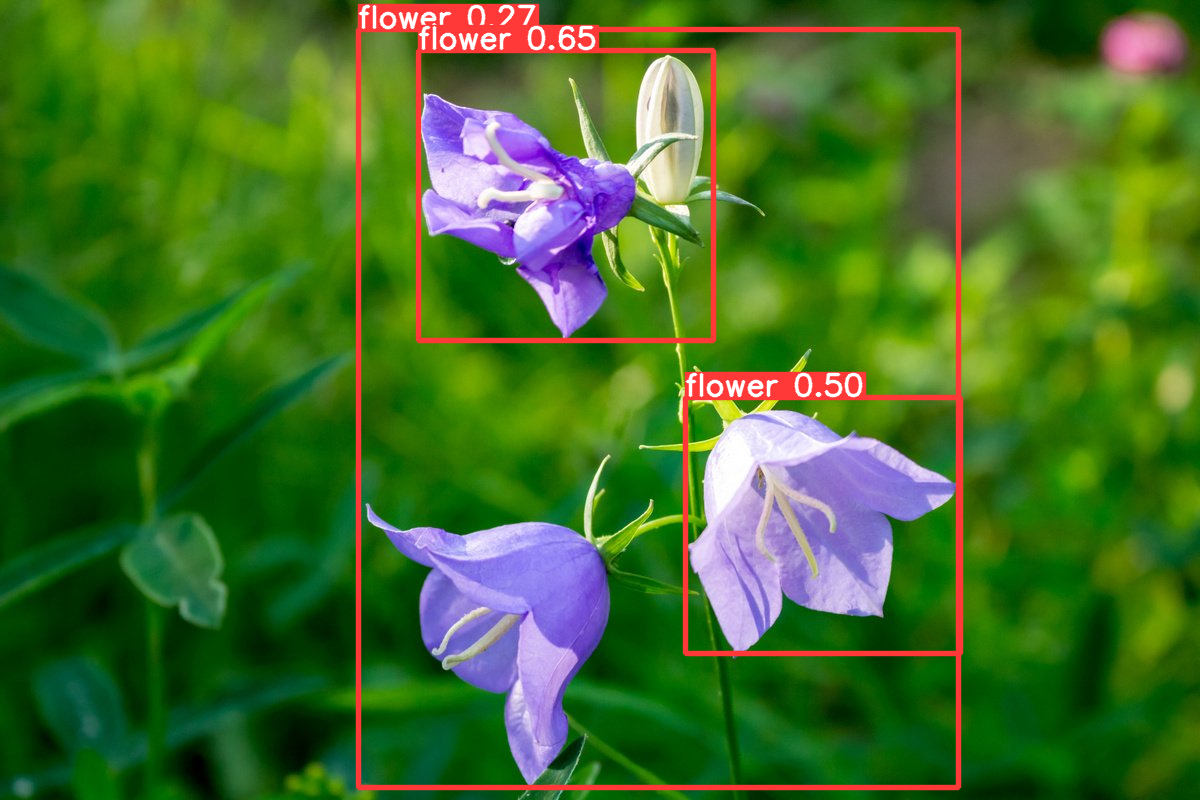

In [ ]:
image_url = 'https://cdn.botanichka.ru/wp-content/uploads/2021/03/16-populyarnyih-rasteniy-tsvetki-kotoryih-i-krasivyi-i-vkusnyi-18.jpg'
run_yolo(yolo, image_url)


Found https://vsegda-pomnim.com/uploads/posts/2022-04/1650251222_30-vsegda-pomnim-com-p-dva-tsvetka-foto-35.jpg locally at 1650251222_30-vsegda-pomnim-com-p-dva-tsvetka-foto-35.jpg
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
image 1/1 /content/1650251222_30-vsegda-pomnim-com-p-dva-tsvetka-foto-35.jpg: 448x640 3 flowers, 43.9ms
Speed: 4.1ms preprocess, 43.9ms inference, 2.8ms postprocess per image at shape (1, 3, 448

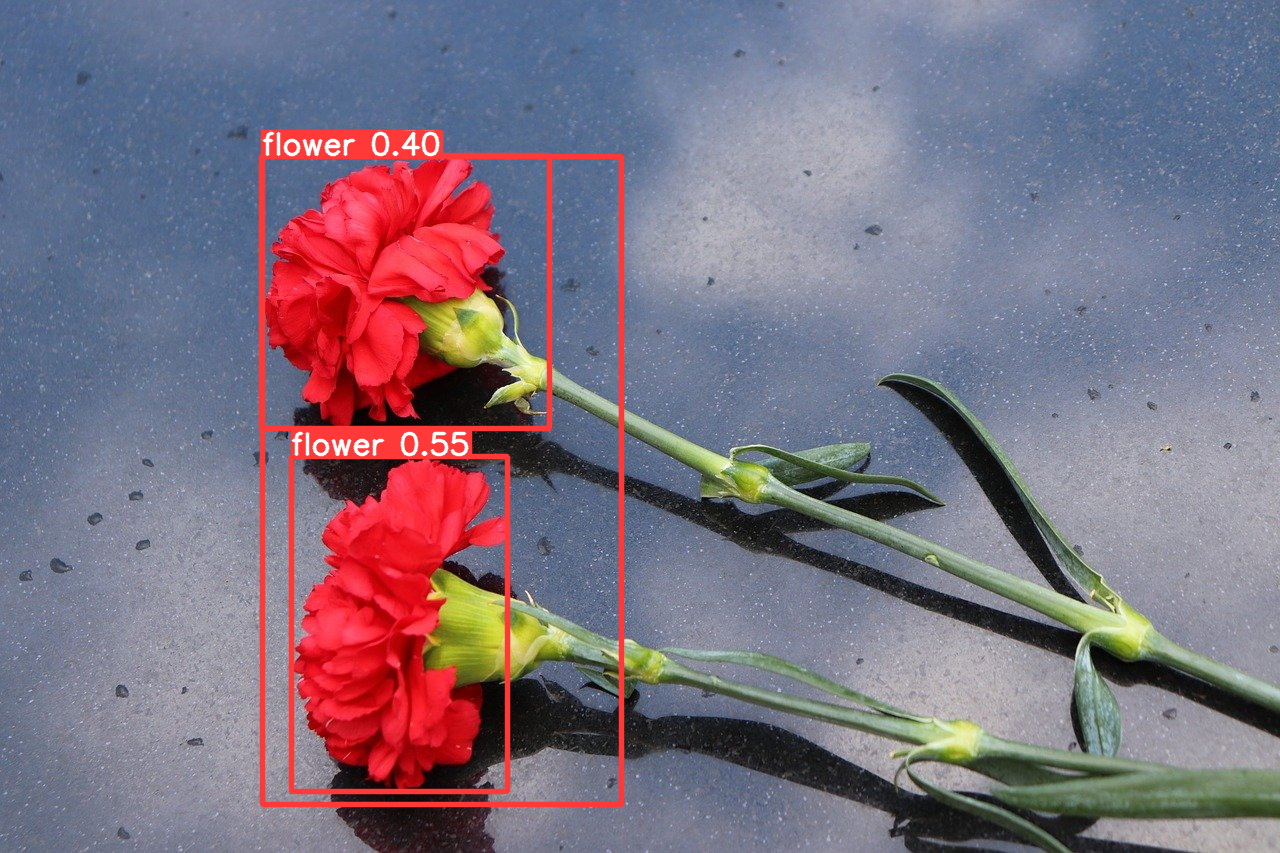

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camer

In [ ]:
image_url = 'https://vsegda-pomnim.com/uploads/posts/2022-04/1650251222_30-vsegda-pomnim-com-p-dva-tsvetka-foto-35.jpg'
run_yolo(yolo, image_url)